Read output txt file from elastix and locate where they are in the brain

In [17]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import matplotlib.pyplot as plt

import skimage
from skimage import io

import random

import seaborn as sns


In [2]:
points_name=fdialog.askopenfile( title='Select the downsampled points').name

atlas_name=fdialog.askopenfile( title='Select the corresponding atlas').name

outdir = fdialog.askdirectory(title='Please select the output directory')

atlas= sitk.ReadImage(atlas_name)

atlas.GetSize()

(516, 374, 340)

In [3]:
# csv_name=fdialog.askopenfile(initialdir='D:\', title='Select the csv file with labels').name

# atlas_labels= pd.read_csv(csv_name)

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [4]:
Read the output points
output=open(points_name,'r')
outputpoint= output.readlines()

### The next 3 cells are only for points that are transformed(after sample2ara)

In [131]:
#This section is only for points that are transformed(after sample2ara)
key_word='OutputIndexFixed'
length=len(key_word)

all_points=[]
for lines in outputpoint:
    start= lines.find('OutputIndexFixed')
    this_line=lines[start+length+5:start+length+17] 
    this_line= this_line.split(' ')
    mypoints=[int(stuff) for stuff in this_line if stuff.isnumeric()]
    all_points.append(mypoints)

#this is a very stupid way of finding the output points
# note that we convert string into integer here

In [ ]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

In [ ]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

f3=[]
for x in atlas_labels['id']:
    intID = int(x)
    f3.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for test in unique_id:
    if test not in f3:
        print(test,'this index does not exist in allen reference atlas, consider possible suboptimal image registration')
        warnings.warn('Consider possible suboptimal image registration')

### The next cells are only for points that are not transformed (after ara2sample)

In [5]:
# This section is only for points that are not transformed (after ara2sample)
all_points=[]
for lines in outputpoint[2:]:
    this_line= lines.split (' ')
    mypoints= [int(stuff) for stuff in this_line]
    all_points.append(mypoints)

In [7]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

our_regionWcounts.to_excel(outdir+'/RegionCounts.xlsx')

In [8]:
our_regionWcounts['safe_name']

0       Primary somatosensory area barrel field layer 4
1                        Dorsal auditory area layer 2/3
2                          Dorsal auditory area layer 4
3                     Anterolateral visual area layer 5
4                      Anteromedial visual area layer 4
5        Primary somatosensory area upper limb layer 6a
6                            Primary motor area Layer 5
7      Primary somatosensory area barrel field layer 6a
8       Primary somatosensory area upper limb layer 2/3
9         Primary somatosensory area upper limb layer 4
10                          Rostrolateral area layer 6b
11                    Anterolateral visual area layer 4
12            Primary somatosensory area trunk layer 6a
13                         Dorsal auditory area layer 5
14                  Anterolateral visual area layer 2/3
15     Primary somatosensory area barrel field layer 6b
16        Primary somatosensory area upper limb layer 5
17                                      corpus c

In [9]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

f3=[]
for x in atlas_labels['id']:
    intID = int(x)
    f3.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for test in unique_id:
    if test not in f3:
        print(test,'this index does not exist in allen reference atlas, consider possible suboptimal image registration')
        warnings.warn('Consider possible suboptimal image registration')
        

        
# Turns out these big numbers exist in atlas but have no name in the json file..ask on allen brain map community forum
# the 0 index is points out of the brain b/c registration problem

0 this index does not exist in allen reference atlas, consider possible suboptimal image registration
312782592 this index does not exist in allen reference atlas, consider possible suboptimal image registration
182305696 this index does not exist in allen reference atlas, consider possible suboptimal image registration
182305712 this index does not exist in allen reference atlas, consider possible suboptimal image registration
312782560 this index does not exist in allen reference atlas, consider possible suboptimal image registration


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Consider possible suboptimal image registration
  


In [10]:
#Plot the result

our_regionWcounts=our_regionWcounts.sort_values(by=['counts'])

percent=100*our_regionWcounts['counts']/np.sum(our_regionWcounts['counts'])

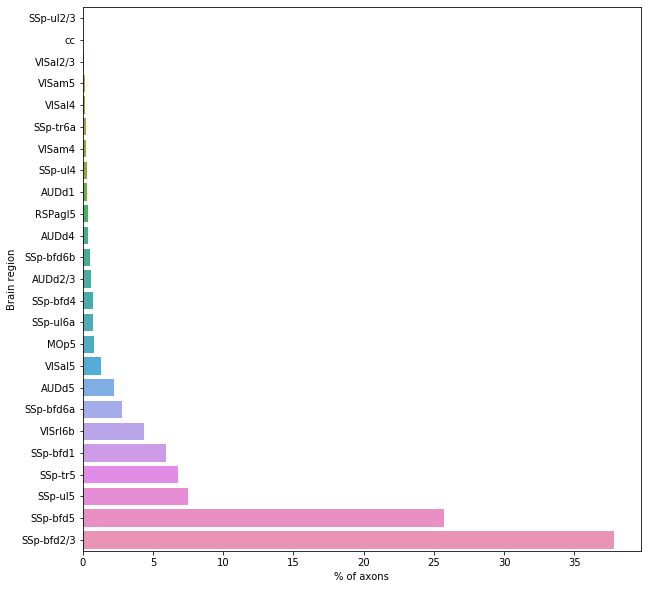

In [11]:
fig, ax = plt.subplots(figsize=[10,10])
my_plot=sns.barplot(y="acronym", x=percent, data=our_regionWcounts)
ax.set(xlabel='% of axons', ylabel='Brain region')
sns.set_context("talk")
sns.set_palette("pastel")
fig.savefig(outdir+"/RegionPlot.svg")

In [12]:
# Now project downsampled points into tiff to see if they make sense
svolume=np.zeros(atlas.GetSize())
#columns, rows, planes

zplanes=[]
for i in all_points:
    zplanes.append( i[2])
zplanes=np.unique(zplanes)
zplanes

array([114, 115, 116, 117, 120, 121, 122, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265])

In [13]:
temp=np.zeros(atlas.GetSize()[0:2])
thepoints=np.asarray(all_points)

for i in zplanes:
    index= thepoints[:,2]==i
    uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
    for j, lines in enumerate(uindex):
        coord1,coord2=lines[0:2]
        temp[coord1][coord2]= counts[j]
    svolume[:,:,i]=temp #write this in 
    temp=np.zeros(atlas.GetSize()[0:2]) #reset the empty plane after each z

In [14]:
for j, lines in enumerate(uindex):
    coord1,coord2=lines[0:2]
    temp[coord1][coord2]= counts[j]

displaying plane 206


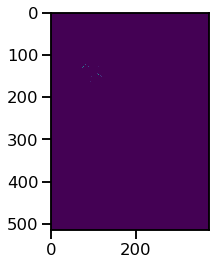

In [22]:
ztoshow=random.choice(zplanes)
plt.imshow(svolume[:,:,ztoshow])
print(f'displaying plane {ztoshow}' )

In [23]:
coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
#for some reason, if just save stuff as tiff, it will save x planes of yz view
#here we shift the 3rd dimension with the first dimension to obtain xy view

io.imsave(outdir+'/DS_points.tif',coronal_planetmp)

C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/AL092/DS_points.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
